# 🌲 Hybrid Model: XGBoost + Random Forest for Load Forecasting

In [1]:
!pip install xgboost scikit-learn pandas matplotlib

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


## 📊 Load and Normalize Data

In [3]:
!pip install openpyxl

In [4]:

# Load dataset (replace with your CSV path if needed)
excel_path = 'test_dataframes.xlsx'
xls = pd.ExcelFile(excel_path)

combined_data = []

for sheet in xls.sheet_names:
    print(f"Reading sheet: {sheet}")
    data = xls.parse(sheet)
    data = data.select_dtypes(include=[np.number])  # Only numeric columns
    if data.shape[1] < 2:
        print(f"Skipping sheet {sheet} due to insufficient numeric data.")
        continue
    combined_data.append(data)

# Combine all sheets
df = pd.concat(combined_data, axis=0).reset_index(drop=True)
print("\nCombined data shape:", df.shape)

# Features and target
features = ['week_X-2', 'week_X-3', 'week_X-4', 'MA_X-4', 'hourOfDay', 'T2M_toc']
target = 'DEMAND'

# Normalize features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Split data
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Reading sheet: Week 15, Apr 2019
Reading sheet: Week 21, May 2019
Reading sheet: Week 24, Jun 2019
Reading sheet: Week 29, Jul 2019
Reading sheet: Week 33, Aug 2019
Reading sheet: Week 37, Sep 2019
Reading sheet: Week 41, Oct 2019
Reading sheet: Week 44, Nov 2019
Reading sheet: Week 51, Dec 2019
Reading sheet: Week 01, Jan 2020
Reading sheet: Week 06, Feb 2020
Reading sheet: Week 10, Mar 2020
Reading sheet: Week 20, May 2020
Reading sheet: Week 24, Jun 2020

Combined data shape: (2352, 11)


## 🌲 Train Random Forest and XGBoost

In [5]:

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Train XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)


## 🤖 Hybrid Prediction (Average of RF and XGBoost)

In [6]:

y_pred_hybrid = (y_pred_rf + y_pred_xgb) / 2


## 📈 Evaluation Metrics

In [7]:

def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    msre = np.mean(((y_true - y_pred) / y_true)**2)
    nmse = mse / np.var(y_true)
    return [mse, rmse, mape, msre, nmse]

metrics_rf = evaluate(y_test, y_pred_rf)
metrics_xgb = evaluate(y_test, y_pred_xgb)
metrics_hybrid = evaluate(y_test, y_pred_hybrid)

labels = ['MSE', 'RMSE', 'MAPE', 'MSRE', 'NMSE']
print('RF:', metrics_rf)
print('XGB:', metrics_xgb)
print('Hybrid:', metrics_hybrid)


RF: [5061.221316157193, np.float64(71.14226111220526), 4.358377459304529, np.float64(0.003392091046188489), np.float64(0.1517571423761738)]
XGB: [4859.308383974814, np.float64(69.70873965274953), 4.333534402028122, np.float64(0.003210220593777595), np.float64(0.1457029258772879)]
Hybrid: [4838.739004153307, np.float64(69.56104516288774), 4.311776122160735, np.float64(0.0032241034165655835), np.float64(0.14508616756794523)]


## 📊 Plot Evaluation Metrics

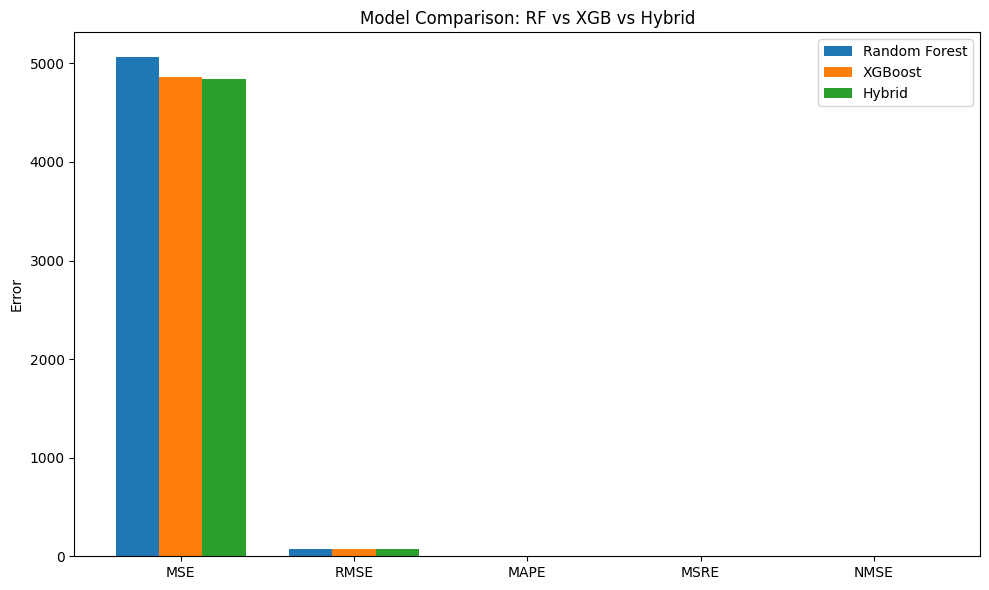

In [8]:

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width, metrics_rf, width, label='Random Forest')
ax.bar(x, metrics_xgb, width, label='XGBoost')
ax.bar(x + width, metrics_hybrid, width, label='Hybrid')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.title("Model Comparison: RF vs XGB vs Hybrid")
plt.ylabel("Error")
plt.tight_layout()
plt.show()


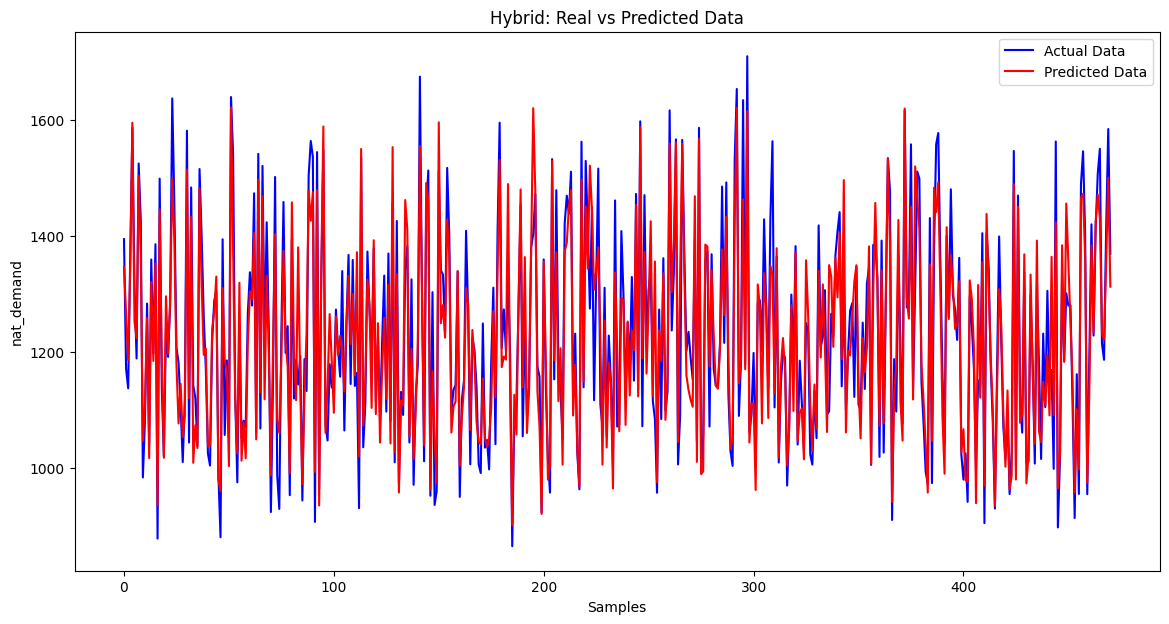

In [10]:
predictions = y_pred_hybrid
plt.figure(figsize=(14, 7))
plt.plot(np.array(y_test), color='blue', label='Actual Data')
plt.plot(predictions, color='red', label='Predicted Data')
plt.title('Hybrid: Real vs Predicted Data')
plt.xlabel('Samples')
plt.ylabel('nat_demand')
plt.legend()
plt.show()